In [61]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import numpy as np
import pandas as pd
import glob

In [63]:
import sys
sys.path.append('../src') 

In [64]:
from gi import event_size, fiducial_df, twocluster_df, event_mult, d12, dtz, select_image_from_df 
from cnn_plot import histoplot, plot_amplitude, plot_image, scatter_xyz

# giBGO
- Shows the data selection and reduction.
- The input df are:
    -  "isensor_data", with the counts in phe in each of the SiPMs.
    -  "gamma_interactions" with the locations in which the gamma interacted in the crystal
    -  "global_pars" with data about the run (dimensions, crystal material)
    -  "sensor_positions", with the position of sensors.

- The nb illustrates the flow o the algorithm to prepara the data for the CNN (prepareData.py in this directory).
    - from "isensor_data", one extracts the images to be analyzed.
    - from "gamma_interactions", one extracts the metadata.
 
 - The selection flow is:
    1. Fraction of events interacting in crystal. This is found from the ration between the total number of gammas that were shot (in global_pars) and the size o the "gamma_interaction" df.
    2. Fiducial cuts (events contained in crystal).
    3. Energy cut (events are near the peak).
  
- The list of events that passes the above cuts is used to select events in the "sensor_data" df. Finally, a df2c dataframe is produced, with the metadata (for each interaction we keep two potential clusters, x1,y1,e1, x2,y2,e2, which can be eventually identical).
  

## BGO

## Data directories

In [65]:
g4dir = "/Users/jjgomezcadenas/Data/G4Prods/crystalGI/G4BGOH1"
fid = "isensor_data_bgo_10.csv"
fgi = "gamma_interactions_bgo_10.csv"
fgp = "global_pars_10.csv"
fsp = "sensor_positions.csv"

## Read out global parameters

In [66]:
dfgp = pd.read_csv(f"{g4dir}/{fgp}", header=0)
dfgp

,seed,timeBinning,gammaEnergy,crystalWidth,crystalLength,material,sipmXY,numberOfEvents
0,123400010,200,0.511,48,22.4,BGO,6,20000


In [67]:
cw = dfgp.crystalWidth.values[0]
cl = dfgp.crystalLength.values[0]
nn = dfgp.numberOfEvents.values[0]
ge = dfgp.gammaEnergy.values[0]
mat = dfgp.material.values[0]
sxy = dfgp.sipmXY[0]
npx = cw//sxy
print(f"material = {mat}, crystal width = {cw}, length = {cl} nof = {nn}, npixels ={npx} x {npx}")

material = BGO, crystal width = 48, length = 22.4 nof = 20000, npixels =8 x 8


## Readout gamma interactions and prepare metadata (2c df)

In [68]:
dfgi = pd.read_csv(f"{g4dir}/{fgi}", header=0).sort_values(by='event')
dfgi.head(10)

,event,time,x,y,z,edep
8,180000,12.0,8.0,-22.1,-7.5,511.0
27,180001,44.7,21.8,-8.9,-0.0,237.5
26,180001,38.0,23.6,-8.2,0.3,273.5
39,180002,12.4,-17.6,-8.7,-7.4,289.5
40,180002,18.8,-17.2,-10.5,-8.0,221.5
55,180003,29.4,-10.3,6.3,-2.3,175.3
54,180003,29.3,-10.3,6.3,-2.3,335.7
66,180004,8.7,-6.9,-12.1,-9.9,247.8
65,180004,4.1,-5.9,-11.2,-9.9,263.2
79,180005,10.9,6.9,5.4,-8.7,370.7


In [69]:
x_int = event_size(dfgi)/nn
print(f"fraction of events interacting in crystal = {x_int}")

fraction of events interacting in crystal = 0.8604


### Define a fiducial dataframe

In [70]:
dfx = fiducial_df(dfgi, d=cw, z=cl)
dfx.head(10)

,event,time,x,y,z,edep,etot,ntrk
0,180000,12.0,8.0,-22.1,-7.5,511.0,511.0,1
1,180001,44.7,21.8,-8.9,-0.0,237.5,511.0,2
2,180001,38.0,23.6,-8.2,0.3,273.5,511.0,2
3,180002,12.4,-17.6,-8.7,-7.4,289.5,511.0,2
4,180002,18.8,-17.2,-10.5,-8.0,221.5,511.0,2
5,180003,29.4,-10.3,6.3,-2.3,175.3,511.0,2
6,180003,29.3,-10.3,6.3,-2.3,335.7,511.0,2
7,180004,8.7,-6.9,-12.1,-9.9,247.8,511.0,2
8,180004,4.1,-5.9,-11.2,-9.9,263.2,511.0,2
9,180005,10.9,6.9,5.4,-8.7,370.7,511.0,2


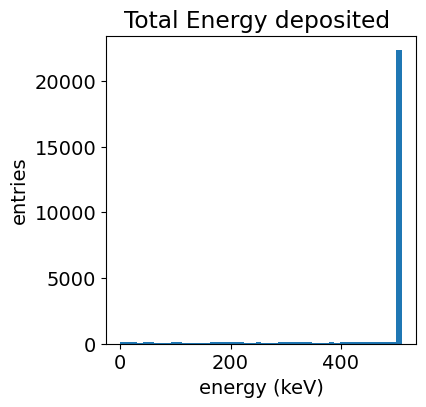

In [71]:
b, e = histoplot(dfx.etot, 'energy (keV)', "entries", bins=50, figsize=(6,6),
                title="Total Energy deposited ")

In [72]:
print(f" Fraction of events in peak ={b[-1]/np.sum(b)}")

 Fraction of events in peak =0.8172735590118939


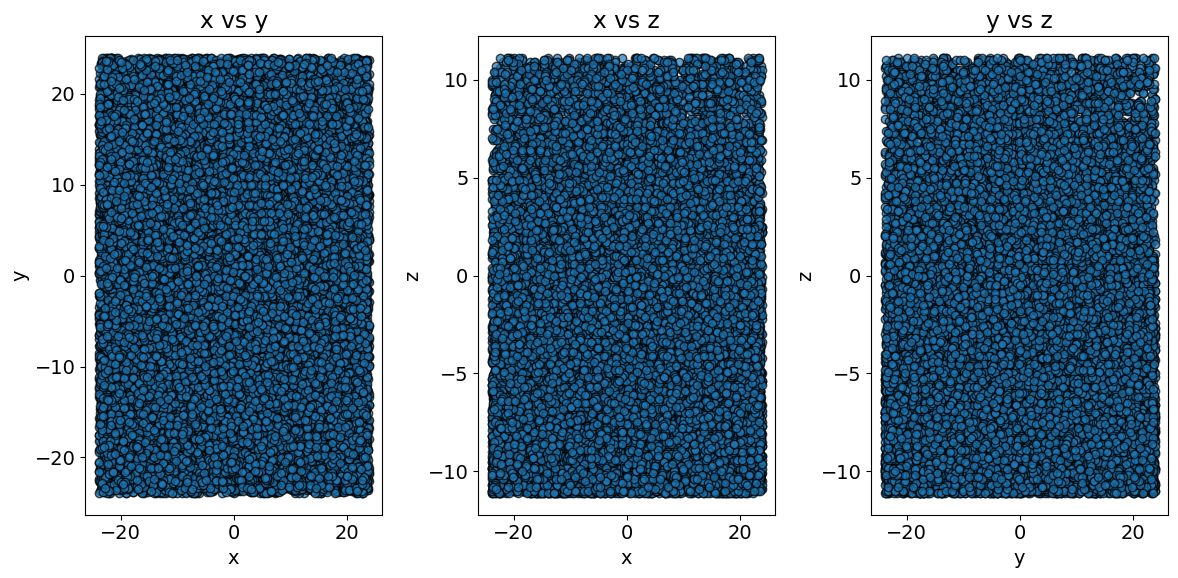

In [73]:
scatter_xyz(dfx.x,dfx.y,dfx.z, figsize=(12, 6))

In [74]:
print(f" mean of x : {(np.mean(dfx.x.values)):.2f}")
print(f" mean of y : {np.mean(dfx.y.values):.2f}")
print(f" mean of z : {np.mean(dfx.z.values):.2f}")

 mean of x : 0.17
 mean of y : -0.06
 mean of z : -2.76


### Cut in energy

In [75]:
ec = 0.98 *ge*1000 # in keV
print(f"cutoff energy = {ec:.2f}")
dfe = dfx[dfx.etot>ec]

cutoff energy = 500.78


In [76]:
x_e = event_size(dfe)/nn
print(f"fraction of events with e > {ec:.1f} keV = {x_e}")

fraction of events with e > 500.8 keV = 0.66745


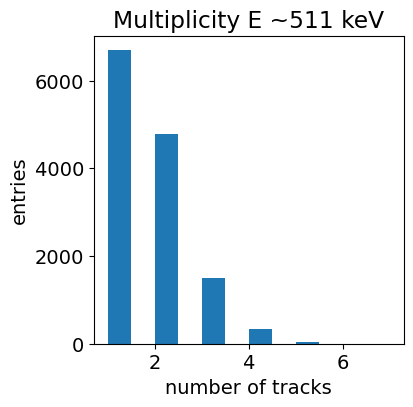

In [21]:
b, e = histoplot(event_mult(dfe), 'number of tracks', "entries", bins=12, figsize=(6,6),
                title="Multiplicity E ~511 keV")

### two cluster data frame (2cdf)

In [22]:
df2c = twocluster_df(dfe).drop('index', axis=1)
df2c.head(10)

,event,etot,ntrk,t1,x1,y1,z1,e1,t2,x2,y2,z2,e2
0,180000,511.0,1,12.0,8.0,-22.1,-7.5,511.0,12.0,8.0,-22.1,-7.5,511.0
1,180001,511.0,2,38.0,23.6,-8.2,0.3,273.5,44.7,21.8,-8.9,-0.0,237.5
2,180002,511.0,2,12.4,-17.6,-8.7,-7.4,289.5,18.8,-17.2,-10.5,-8.0,221.5
3,180003,511.0,2,29.3,-10.3,6.3,-2.3,335.7,29.4,-10.3,6.3,-2.3,175.3
4,180004,511.0,2,4.1,-5.9,-11.2,-9.9,263.2,8.7,-6.9,-12.1,-9.9,247.8
5,180005,511.0,2,2.8,5.3,4.5,-10.2,140.3,10.9,6.9,5.4,-8.7,370.7
6,180006,511.0,1,13.3,16.1,23.0,-7.1,511.0,13.3,16.1,23.0,-7.1,511.0
7,180007,511.0,2,71.0,10.4,7.4,10.2,272.5,80.3,8.3,9.2,9.8,238.5
8,180011,511.0,3,58.8,9.7,-13.2,6.5,148.5,65.0,9.5,-14.7,7.6,18.3
9,180012,511.0,2,25.5,18.1,-1.6,-3.4,296.9,27.2,17.6,-1.6,-3.6,214.1


In [23]:
dfpe = df2c[df2c.ntrk==1]
dfco = df2c[df2c.ntrk>1]
print(f"Fraction of photoelectric events  = {event_size(dfpe)/event_size(df2c)}, of compton = {event_size(dfco)/event_size(df2c)}")
print(f"wrt total interactions  = {event_size(dfpe)/nn}, compton = {event_size(dfco)/nn}")

Fraction of photoelectric events  = 0.5010862236871676, of compton = 0.4989137763128324
wrt total interactions  = 0.33445, compton = 0.333


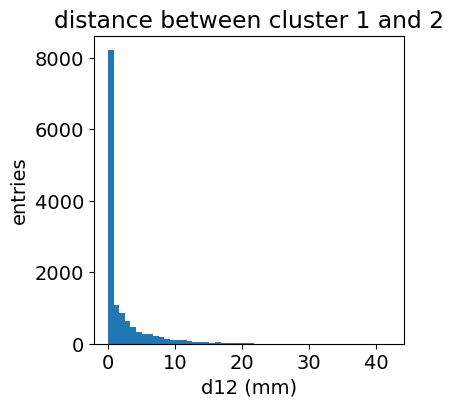

In [24]:
b, e = histoplot(d12(df2c), 'd12 (mm)', "entries", bins=50, figsize=(6,6),
                title="distance between cluster 1 and 2")

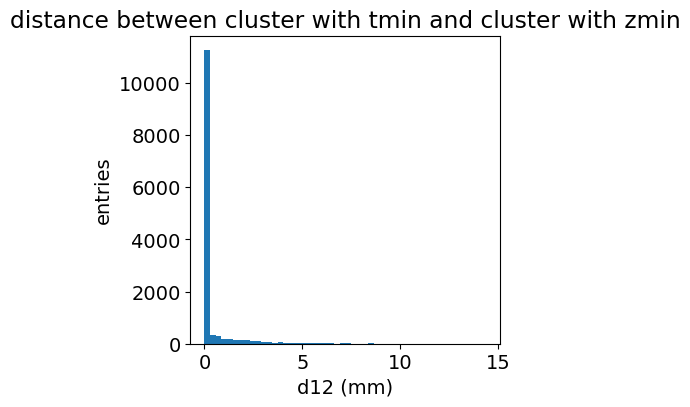

In [25]:
b, e = histoplot(dtz(df2c), 'd12 (mm)', "entries", bins=50, figsize=(6,6),
                title="distance between cluster with tmin and cluster with zmin")

### Z asigment
- The plot above shows that most of the time the assigment of tmin to zmin works well, and results in zero error, with a small tail, which extends up to 5 mm.

## Read sensor data

In [26]:
dfgi = pd.read_csv(f"{g4dir}/{fid}", header=0).sort_values(by='event')
dfgi.head(10)

,event,sensor_id,amplitude
507,180000,20,21
481,180000,45,42
482,180000,3,23
483,180000,26,56
484,180000,43,63
485,180000,53,36
486,180000,28,35
487,180000,2,21
488,180000,63,26
489,180000,0,26


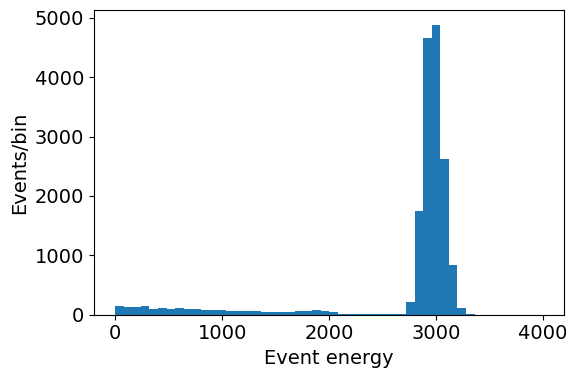

In [27]:
b, e = plot_amplitude(dfgi, num_bins = 50, xmin=0, xmax=4e+3,figsize=(6, 4), title="")

### Select events that pass the cuts of gamma DF (df2c)

In [28]:
sel_gi = df2c.event.values

In [29]:
# Filter the DataFrame using .isin() method
dfi = dfgi[dfgi['event'].isin(sel_gi)]
event_size(dfi)/event_size(dfgi)

0.7715293029707548

In [30]:
event_size(dfi)/event_size(df2c)

1.0

### Sensor positions

In [31]:
dfs = pd.read_csv(f"{g4dir}/{fsp}", header=0)
dfs.head(10)

,sensor_id,sensor_x,sensor_y,sensor_z
0,0,-21,-21,11.7
1,1,-21,-15,11.7
2,2,-21,-9,11.7
3,3,-21,-3,11.7
4,4,-21,3,11.7
5,5,-21,9,11.7
6,6,-21,15,11.7
7,7,-21,21,11.7
8,8,-15,-21,11.7
9,9,-15,-15,11.7


In [32]:
x_spatial = dfs.sensor_x.values
y_spatial = dfs.sensor_y.values

### Plot a few images

In [55]:
evt_indx = 10
event = sel_gi[evt_indx]

In [56]:
meta = df2c.iloc[evt_indx]
image = select_image_from_df(dfi,sel_gi[evt_indx])
print(f"Select event index = {evt_indx}, event = {int(meta.event)} (={sel_gi[evt_indx]})")

Select event index = 10, event = 180013 (=180013)


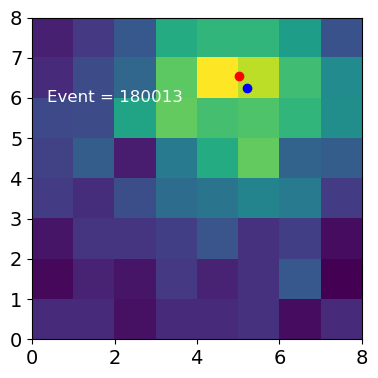

In [59]:
plot_image(image, meta, x_spatial, y_spatial, figsize=(4, 4), debug=False)

Select event index = 100, event = 180142 (=180142)


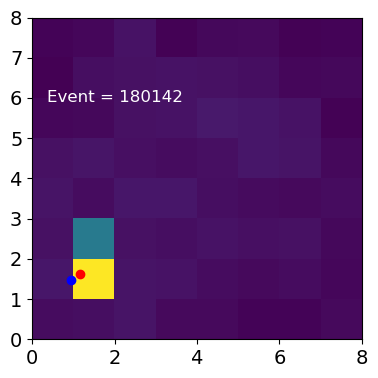

In [60]:
evt_indx = 100
event = sel_gi[evt_indx]
meta = df2c.iloc[evt_indx]
image = select_image_from_df(dfi,sel_gi[evt_indx])
print(f"Select event index = {evt_indx}, event = {int(meta.event)} (={sel_gi[evt_indx]})")
plot_image(image, meta, x_spatial, y_spatial, figsize=(4, 4), debug=False)